# Demonstrating `mobile-env`

`mobile-env` is a simple and open environment for training, testing, and evaluating autonomous coordination
approaches for wireless mobile networks.

* `mobile-env` is written in pure Python and can be installed easily via [PyPI](https://pypi.org/project/mobile-env/)
* It allows simulating various scenarios with moving users in a cellular network with multiple base stations
* `mobile-env` implements the [OpenAI Gym](https://gym.openai.com/) interface such that it can be used with all common frameworks for reinforcement learning
* It supports both centralized, single-agent control and distributed, multi-agent control
* It can be configured easily (e.g., adjusting number and movement of users, properties of cells, etc.)
* It is also easy to extend `mobile-env`, e.g., implementing different observations, actions, or reward

As such `mobile-env` is a simple platform to evaluate and compare different coordination approaches in a meaningful way.



**Demonstration Steps:**

This demonstration consists of the following steps:

1. Installation and usage of `mobile-env` with a dummy actions
2. Configuration of `mobile-env` and adjustment of the observation space (optional)
3. Training a single-agent reinforcement learning approach with [`stable-baselines3`](https://github.com/DLR-RM/stable-baselines3)
4. Training a multi-agent reinforcement learning approach with [Ray RLlib](https://docs.ray.io/en/latest/rllib.html)


## Step 1: Install and Test `mobile-env` With Dummy Actions

Installing `mobile_env` via PyPI is very simple:

In [1]:
# installation via PyPI
!pip install mobile-env

`mobile_env` comes with a set of predefined scenarios, registered as Gym environments, that can be used out of the box for quick experimentation.

In [1]:
import gym
import matplotlib.pyplot as plt
# importing mobile_env automatically registers the predefined scenarios in Gym
import mobile_env


# create a small mobile environment for a single, centralized control agent
env = gym.make("mobile-small-central-v0")

print(f"\nSmall environment with {env.NUM_USERS} users and {env.NUM_STATIONS} cells.")

pygame 2.1.0 (SDL 2.0.16, Python 3.8.11)
Hello from the pygame community. https://www.pygame.org/contribute.html

Small environment with 5 users and 3 cells.


Here, we consider a small scenario (called `"mobile-small-central-v0"`) with 5 users and 3 cells.
As the users move around, the goal is to connect the users to suitable cells, ensuring that all users have a good Quality of Experience (QoE).

Using coordinated multipoint (CoMP), users can connect to multiple cells simultaneously.
Connecting to more cells increases the user's data rate but also increases competition for resources and may decrease data rates of other users.
Therefore, a good coordination policy needs to balance this trade-off, depending on available resources and users' positions (affecting their path loss).

To measure QoE, `mobile-env` defaults to a logarithmic utility function of the users' data rate, where -20 indicates bad QoE and +20 indicates good QoE. This can be easily configured and changed.

![Utility plot](../docs/images/utility.png)

To get started, we will use random dummy actions.

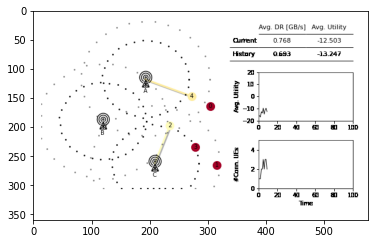

In [2]:
from IPython import display

# run the simulation for 10 time steps
done = False
obs = env.reset()
for _ in range(10):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, done, info = env.step(dummy_action)

    # render the environment
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

The rendered environment shows the three cells as cell towers with circles indicating their range.
The five moving users are shown as small circles, where the number indicates the user ID and
the color represents the user's current QoE (red = bad, yellow = ok, green = good).

A line between a user and a cell indicates that the user is connected to the cell.
Again, the line color indicates the QoE that's achieved via the connection.
Note that users can connect to multiple cells simultaneously using coordinated multipoint (CoMP).

Before training a reinforcement learning agent to properly control cell selection, we will look at some configuration options of `mobile-env` next.



## Step 2: Configure `mobile-env` (Optional)

### Predefined Scenarios

Configuration is optional.
We can also choose between one of the [three predefined scenarios](https://mobile-env.readthedocs.io/en/latest/components.html#scenarios) (small, medium, and large) without having to configure anything.

By default, these are available for either a single, centralized agent (e.g., `"mobile-small-central-v0"`)
or multiple agents (e.g., `"mobile-small-ma-v0"`), which affects the observations, actions, and reward.

In [3]:
# predefined small scenarios
from mobile_env.scenarios.small import MComSmall

# easy access to the default configuration
MComSmall.default_config()

{'width': 200,
 'height': 200,
 'EP_MAX_TIME': 100,
 'seed': 0,
 'reset_rng_episode': False,
 'arrival': mobile_env.core.arrival.NoDeparture,
 'channel': mobile_env.core.channels.OkumuraHata,
 'scheduler': mobile_env.core.schedules.ResourceFair,
 'movement': mobile_env.core.movement.RandomWaypointMovement,
 'utility': mobile_env.core.utilities.BoundedLogUtility,
 'handler': mobile_env.handlers.central.MComCentralHandler,
 'bs': {'bw': 9000000.0, 'freq': 2500, 'tx': 30, 'height': 50},
 'ue': {'velocity': 1.5, 'snr_tr': 2e-08, 'noise': 1e-09, 'height': 1.5},
 'arrival_params': {'ep_time': 100, 'reset_rng_episode': False},
 'channel_params': {},
 'scheduler_params': {},
 'movement_params': {'width': 200, 'height': 200, 'reset_rng_episode': False},
 'utility_params': {'lower': -20, 'upper': 20, 'coeffs': (10, 0, 10)}}

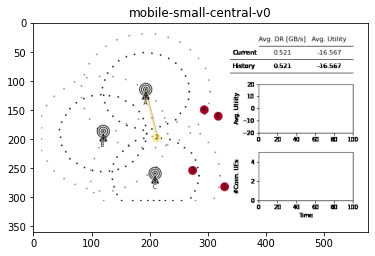

In [4]:
def plot_env(env_name):
    """Create env, take a random step, and then render the environment."""
    env = gym.make(env_name)
    env.reset()
    env.step(env.action_space.sample())
    plt.imshow(env.render(mode='rgb_array'))
    plt.title(env_name)

# plot small env from earlier
plot_env("mobile-small-central-v0")

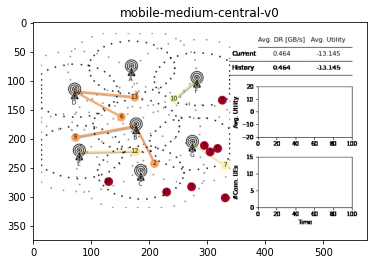

In [5]:
plot_env("mobile-medium-central-v0")

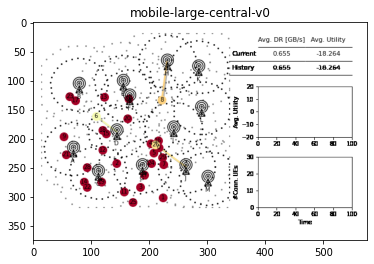

In [6]:
plot_env("mobile-large-central-v0")

### Custom Scenario

It is also easy to define a custom scenario by subclassing `mobile-env`'s `MComCore` base class.

Here, we create a custom scenario with two cells and three users, where one user is stationary and the other two users move quickly with 10 m/s.

We also configure the environment to simulate each episode with identical user positions and movement. By default, users appear and move randomly in each episode.
We also set the episode length to 10 (instead of default 100 steps).

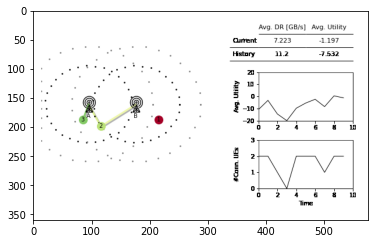

In [7]:
from mobile_env.core.base import MComCore
from mobile_env.core.entities import BaseStation, UserEquipment


class CustomEnv(MComCore):
    # overwrite the default config
    @classmethod
    def default_config(cls):
        config = super().default_config()
        config.update({
            # 10 steps per episode
            "EP_MAX_TIME": 10,
            # identical episodes
            "seed": 1234,
            'reset_rng_episode': True,
        })
        # faster user movement
        config["ue"].update({
            "velocity": 10,
        })
        return config

    # configure users and cells in the constructor
    def __init__(self, config={}):
        # load default config defined above; overwrite with custom params
        env_config = self.default_config()
        env_config.update(config)

        # two cells next to each other; unpack config defaults for other params
        stations = [
            BaseStation(bs_id=0, pos=(50, 100), **env_config["bs"]),
            BaseStation(bs_id=1, pos=(100, 100), **env_config["bs"])
        ]

        # users
        users = [
            # two fast moving users with config defaults
            UserEquipment(ue_id=1, **env_config["ue"]),
            UserEquipment(ue_id=2, **env_config["ue"]),
            # stationary user --> set velocity to 0
            UserEquipment(ue_id=3, velocity=0, snr_tr=env_config["ue"]["snr_tr"], noise=env_config["ue"]["noise"],
                          height=env_config["ue"]["height"]),
        ]

        super().__init__(stations, users, config)


# init and render the custom scenario
env = CustomEnv()
env.reset()
for _ in range(10):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, done, info = env.step(dummy_action)

    # render the environment
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Extending `mobile-env`: Tracking custom metrics

`mobile-env` allows to define and track custom metrics during the training and testing phases. It defines an interface for metrics that record values per user equipment (e.g. utility per user), basestation (e.g. number of connections per station) or time step (e.g. average utility of users).

Here, we show as an example how the number of overall connections, connections per station and utility per user can be monitored.

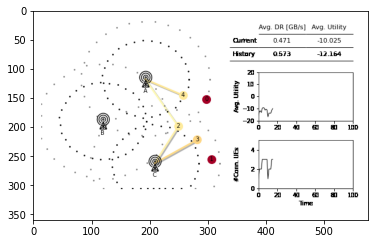

In [ ]:
# overall number of active connections
def overall_connections(sim):
    return sum([len(conns) for conns in sim.connections.values()])

# monitors utility per user equipment
def user_utility(sim):
    return {ue.ue_id: utility for ue, utility in sim.utilities.items()}

# number of connections per basestation
def station_connections(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections.items()}



# add custom metrics to config of environment
config = {"metrics": {
            "scalar_metrics": {"overall_connections": overall_connections},
            "ue_metrics": {"user_utility": user_utility},
            "bs_metrics": {"stations_connections": station_connections}
            }
         }
    
# pass the configuration to the environment
env = gym.make("mobile-small-central-v0", config=config)
env.reset()

for _ in range(20):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, done, info = env.step(dummy_action)

    # render the environment
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
          
        
# load all tracked results as pandas data frames
scalar_results, ue_results, bs_results = env.monitor.load_results()

# show general specific results
scalar_results

### Extending `mobile-env`: Adding a Handler for a Custom Observation Space

Handlers define the observation and action spaces as well as the reward for an environment.
Hence, when designing a new Markov Decision Process for a reinforcement learning approach, you can quickly validate it by implementing a new handler in `mobile-env`.

Let's first look at the default handler (for single-agent RL) and then add a new handler with a custom observation space.

In [8]:
env.handler.features

['connections', 'snrs', 'utility']

By default, observed features are:
* The current connections between users and cells (binary)
* The signal-to-noise-ratio (SNR) between all users and cells (normalized to [0,1])
* The current utility (i.e., QoE) of each user (normalized to [-1,1])

In [9]:
env = CustomEnv(config={"seed": 42})
obs = env.reset()
obs, reward, done, info = env.step(env.action_space.sample())

print("Raw observations: ", obs)

# connections and SNR are per user and station, utility just per user
obs_per_user = 2 * env.NUM_STATIONS + 1
for ue in range(env.NUM_USERS):
    print(f"\nObservations for user {ue + 1}:")
    offset = ue * obs_per_user
    print(f"Current connections to the {env.NUM_STATIONS} cells: {obs[offset:offset+env.NUM_STATIONS]}")
    print(f"SNR to the {env.NUM_STATIONS} cells: {obs[offset+env.NUM_STATIONS:offset+2*env.NUM_STATIONS]}")
    print(f"Current utility: {obs[offset+2*env.NUM_STATIONS]}")


Raw observations:  [ 0.          0.          0.3470676   1.         -1.          1.
  0.          1.          0.2665389   0.47082826  0.          0.
  0.38201445  1.         -1.        ]

Observations for user 1:
Current connections to the 2 cells: [0. 0.]
SNR to the 2 cells: [0.3470676 1.       ]
Current utility: -1.0

Observations for user 2:
Current connections to the 2 cells: [1. 0.]
SNR to the 2 cells: [1.        0.2665389]
Current utility: 0.47082826495170593

Observations for user 3:
Current connections to the 2 cells: [0. 0.]
SNR to the 2 cells: [0.38201445 1.        ]
Current utility: -1.0


Now, let's extend the observation space by adding an observation that indicates whether a user is connected to any cell at all, i.e., a single binary entry per user.

For that, we create a new handler that inherits from the existing central handler and simply overwrite the relevant parts: The available features and the observations.

In [10]:
from mobile_env.handlers.central import MComCentralHandler
import numpy as np


class CustomHandler(MComCentralHandler):
    # let's call the new observation "any_connection"
    features = MComCentralHandler.features + ["any_connection"]

    # overwrite the observation size per user
    @classmethod
    def ue_obs_size(cls, env) -> int:
        """Increase observations by 1 for each user for the new obs"""
        # previously: connections for all cells, SNR for all cells, utility
        prev_size = env.NUM_STATIONS + env.NUM_STATIONS + 1
        return prev_size + 1

    # add the new observation
    @classmethod
    def observation(cls, env) -> np.ndarray:
        """Concatenated observations for all users"""
        # get all available obs from the env
        obs_dict = env.features()

        # add the new observation for each user (ue)
        for ue_id in obs_dict.keys():
            any_connection = np.any(obs_dict[ue_id]["connections"])
            obs_dict[ue_id]["any_connection"] = int(any_connection)

        # select the relevant obs and flatten into single vector
        flattened_obs = []
        for ue_id, ue_obs in obs_dict.items():
            flattened_obs.extend(ue_obs["connections"])
            flattened_obs.append(ue_obs["any_connection"])
            flattened_obs.extend(ue_obs["snrs"])
            flattened_obs.extend(ue_obs["utility"])

        return flattened_obs

In [11]:
# create the env with the new handler and check the obs
env = CustomEnv(config={"handler": CustomHandler})
obs = env.reset()
obs, reward, done, info = env.step(env.action_space.sample())

print("New, raw observations: ", obs)

# connections and SNR are per user and station, utility just per user
obs_per_user = 2 * env.NUM_STATIONS + 2
for ue in range(env.NUM_USERS):
    print(f"\nObservations for user {ue + 1}:")
    offset = ue * obs_per_user
    print(f"Current connections to the {env.NUM_STATIONS} cells: {obs[offset:offset+env.NUM_STATIONS]}")
    print(f"NEW: Any connection?: {obs[offset+env.NUM_STATIONS]}")
    print(f"SNR to the {env.NUM_STATIONS} cells: {obs[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1]}")
    print(f"Current utility: {obs[offset+2*env.NUM_STATIONS+1]}")

New, raw observations:  [0.0, 0.0, 0, 0.39157578, 1.0, -1.0, 0.0, 0.0, 0, 0.08438771, 1.0, -1.0, 0.0, 1.0, 1, 1.0, 0.021902867, -0.17653753]

Observations for user 1:
Current connections to the 2 cells: [0.0, 0.0]
NEW: Any connection?: 0
SNR to the 2 cells: [0.39157578, 1.0]
Current utility: -1.0

Observations for user 2:
Current connections to the 2 cells: [0.0, 0.0]
NEW: Any connection?: 0
SNR to the 2 cells: [0.08438771, 1.0]
Current utility: -1.0

Observations for user 3:
Current connections to the 2 cells: [0.0, 1.0]
NEW: Any connection?: 1
SNR to the 2 cells: [1.0, 0.021902867]
Current utility: -0.17653752863407135


Now, the observations include an additional entry per user that indicates whether the user is connected to any cell at all. Maybe that's a useful observation for an RL approach?

Let's try to train an RL agent with the custom observations on our custom environment.


## Step 3: Single-Agent RL with `stable-baselines3`

In a single-agent approach, the single RL agent controls cell selection for all users simultaneously.
We can train such a single-agent approach with many different RL frameworks.
A popular example is `stable-baselines3`, using the PPO algorithm.

### Set Up `stable-baselines3`

In [12]:
# first, install stable baselines
!pip install stable-baselines3

     |████████████████████████████████| 174 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 44.6 MB 910 kB/s eta 0:00:011
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663116 sha256=b46cd77a1ec6bbb67079aea8721c0ee6b0ea96cd995b836c4479a53b6a196ae7
  Stored in directory: /Users/stwerner/Library/Caches/pip/wheels/11/36/28/628f4dd3779e4037a6fca1aaed76827ffa4315c3ab6bfadcf6
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.0.0
    Uninstalling cloudpickle-2.0.0:
      Successfully uninstalled cloudpickle-2.0.0
  Attempting uninstall: gym
    Found existing installation: gym 0.21.0
    Uninstalling gym-0.21.0:
      Successfully uninstalled gym-0.21.0


### Train a Single PPO Agent

In [14]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

# create the custom env with the custom handler (obs space) from step 2
env = CustomEnv(config={"handler": CustomHandler})

# train PPO agent on environment. this takes a while
model = PPO(MlpPolicy, env, tensorboard_log='results_sb', verbose=1)
model.learn(total_timesteps=30000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to results_sb\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -5.47    |
| time/              |          |
|    fps             | 168      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | -5.83       |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 2           |
|    time_elapsed         | 21          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011307748 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2   

To visualize training progress, we can use TensorBoard using `tensorboard --logdir results_sb`, i.e., pointing to the TensorBoard log directory that we defined above.

If we run it in another terminal, we can monitor training progress live. After training finishes, we can also show TensorBoard inside the notebook (works on Google CoLab):

In [15]:
# install and load tensorboard
!pip install tensorboard
%load_ext tensorboard

In [18]:
# show training progress on tensorboard
%tensorboard --logdir results_sb

Reusing TensorBoard on port 6006 (pid 19344), started 22:35:08 ago. (Use '!kill 19344' to kill it.)

TensorBoard should show that the agent's reward ("ep_rew_mean") increases with increasing training, indicating that the agent is learning. After 30k training steps, the agent is still learning (reward is still going up; not converged), but the agent already learned a useful policy.

### Test and Visualize the Trained Policy

To get a sense of what the agent learned, we can easily visualize the learned policy with `mobile-env`.

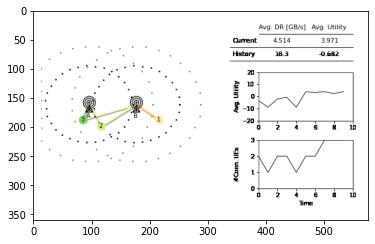

In [19]:
env = CustomEnv(config={"handler": CustomHandler})
obs = env.reset()
done = False

# run one episode with the trained model
while not done:
    action, _ = model.predict(obs)

    # perform step on simulation environment
    obs, reward, done, info = env.step(action)

    # render environment as RGB
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

Indeed, the visualization shows that the trained agent successfully connects all users to the available cells (indicated by the line connections), leading to rather good QoE (yellow to green color).


## Step 4: Multi-Agent RL with Ray RLlib

As alternative to controlling cell selection centrally for all users from a single RL agent, we can also use multi-agent RL, i.e., delegating control to multiple agents that act in parallel.
As an example, we could have each RL agent responsible for the cell selection of a single user. Then we would need as many agents as we have users.
That's what happens in the predefined multi-agent scenarios, e.g., `mobile-small-ma-v0`.

Let's use RLlib to train a multi-agent policy on the `mobile-small-ma-v0` scenario, which has three base stations and five users.

### Set up Ray RLlib

To train a multi-agent approach, we can use Ray RLlib, which supports multi-agent RL out of the box. To register the predefined multi-agent scenario with RLlib, `mobile-env` provides a wrapper `RLlibMAWrapper`.

In [18]:
# install ray RLlib
!pip install ray[rllib]

In [20]:
from ray.tune.registry import register_env

# use the mobile-env RLlib wrapper for RLlib
def register(config):
    import mobile_env
    from mobile_env.wrappers.multi_agent import RLlibMAWrapper

    env = gym.make("mobile-small-ma-v0")
    return RLlibMAWrapper(env)

# register the predefined scenario with RLlib
register_env("mobile-small-ma-v0", register)

### Train a PPO Multi-Agent Policy

Now, that the predefined scenario is registered with RLlib, we can configure and train a multi-agent PPO approach on the scenario with RLlib.

In [27]:
import ray


# init ray with available CPUs (and GPUs) and init ray
ray.init(
  num_cpus=3,
  include_dashboard=False,
  ignore_reinit_error=True,
  log_to_driver=False,
)

2021-12-13 16:47:11,236	INFO worker.py:852 -- Calling ray.init() again after it has already been called.


In [28]:
# configure and run multi-agent PPO
config = {
        # environment configuration:
        "env": "mobile-small-ma-v0",

        # multi-agent configuration (here with shared policy)
        "multiagent": {
            "policies": {"shared_policy"},
            "policy_mapping_fn": (
                lambda agent_id, **kwargs: "shared_policy"),
        },
}

analysis = ray.tune.run("PPO", config=config, local_dir="results_rllib", stop={"timesteps_total": 30000}, checkpoint_at_end=True)

Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


2021-12-13 16:50:31,170	WARNING util.py:165 -- The `start_trial` operation took 1.267 s, which may be a performance bottleneck.


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


2021-12-13 16:52:54,720	WARNING tune.py:582 -- SIGINT received (e.g. via Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C one more time (or send SIGINT/SIGKILL/SIGTERM) to skip. 


Trial name,status,loc
PPO_mobile-small-ma-v0_ef76d_00000,PENDING,


2021-12-13 16:52:54,970	ERROR tune.py:622 -- Trials did not complete: [PPO_mobile-small-ma-v0_ef76d_00000]
2021-12-13 16:52:54,970	INFO tune.py:626 -- Total run time: 343.72 seconds (343.45 seconds for the tuning loop).
2021-12-13 16:52:54,970	WARNING tune.py:630 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


As before, we can check the learning curve on TensorBoard. The corresponding files are in the configured `save_dir=results_rllib`.

The "episode_reward_mean" should increase with increasing training. RLlib also logs many other metrics by default, which can be useful for debugging. 

In [23]:
%tensorboard --logdir results_rllib

### Load and Test the Trained Multi-Agent Policy

Let's load the trained multi-agent model and visualize the learned multi-agent policy:

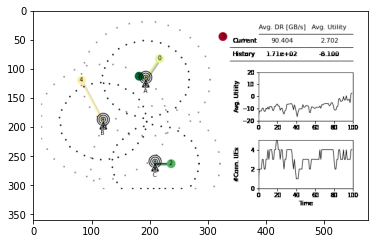

In [26]:
from ray.rllib.agents.ppo import PPOTrainer


# load the trained agent
checkpoint = analysis.get_last_checkpoint()
model = PPOTrainer(config=config, env='mobile-small-ma-v0')
model.restore(checkpoint)

# create the env for testing
env = gym.make("mobile-small-ma-v0")
obs = env.reset()
done = False

# run one episode with the trained model
while not done:
    # gather action from each actor (for each UE)
    action = {}
    for agent_id, agent_obs in obs.items():
        policy_id = config['multiagent']['policy_mapping_fn'](agent_id)
        action[agent_id] = model.compute_action(agent_obs, policy_id=policy_id)

    # apply actions and perform step on simulation environment
    obs, reward, done, info = env.step(action)

    # render environment as RGB
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)